# Predicting customer visits
## Introduction
We are tasked with predicting which day of the week our customers will visit again. This notebook details the steps taken to solve this problem. We get a dataset with weekly visits of 300000 customers. Unfortunately the structure is not ready for machine learning so a lot of data preperation needs to be done. Once the structure is fixed, we do some feature engineering. Finally, using random forests we can predict which day of week a customer will visit.

## Dataset description
Dataset (https://drive.google.com/open?id=1IhZUJa9r44SAhZQQOLB7wEqdVtx6Qtuq) provides information
about shopping mall visits. Each line represents one customer - the first column contains unique customer
identifier and the second column contains indices of the day when customer have visited the mall. The day
with index 1 is a Monday (e. g. 7th is a Sunday, 8th is again a Monday). Indices are within a range of 1 to 1001
(which is equal to 143 full weeks). The task is to predict the first day of the next visit (week 144). For example,
if customer will visit mall on Wednesday, then prediction should be equal to 3:
0. Customer will not visit on the next week
1. Monday
2. Tuesday
3. Wednesday
4. Thursday
5. Friday
6. Saturday
7. Sunday

## Executive Summary

There are many machine learning algorithms which can be used for classification problems. I decided on using Random forests because they are easy to implement, give feature importance and can be top performers if tuned correctly.

We use binary classification models to predict the visit probability for each day of week independantly. Hence, the accuracy for each model varies:
- No visits: ~60%
- Day 1: Monday: ~90%
- Day 2: Tuesday: ~90%
- Day 3: Wednesday: ~90%
- Day 4: Thursday: ~90%
- Day 5: Friday: ~90%
- Day 6: Saturday: ~80%
- Day 7: Sunday: ~80%

Reporting these high classification accuracies can be misleading. For example: Our Day 1 predictions, we get around 90% accuracy because our model is predicting all values will be 0 i.e. no customers are predicted to visit on Monday. Because there are so few monday visits (in comparison to other days and no visits) this is not neccesarily a bad prediction. If our task was to predict Mondays more accurately there are other evaluation criteria we could use to force the model to predict more visits as Monday. However, I decided it would be more important to predict accurately overall and hence left these models as they are.

To get our final prediction we can predict the day of week which has the highest probability for all 8 models. We could also structure this as a multi-label classification problem and try to correctly predict all visit days in the next week. This decision is dependant on how our model will be used for business applications.

As I mention above, random forest give us the feature importance. For every model, the most important feature to predict the day of week was the proportion of days the customer previously visited on that day. This also makes intuitive sense, for example: If a customer has visited the mall a total of 10 times, and 9 out of the 10 times they visit on a Monday, it is reasonable to predict the next time they visit will be on Monday. 

The other very important feature is the proportion of no visit weeks. Again, this makes sense: If we have 2 customers - A and B - Customer A visits at least 1 day a week for 10 weeks while customer B visits only once in 10 weeks. It is reasonable to predict customer A is more likely to visit the next week compared to customer B.

I built 2 [Tableau dashboards]('https://public.tableau.com/profile/ryan3290#!/vizhome/CustomerVisits_0/CustomerVisitDash') to help explain what is happening in this model. 
- Customer Dash is used to see the predictions for an individual customer (visitor_id). This helps us check whether predictions are reasonable.
- Model Feature Dash is used to explore the relationship between the targets (day of week) and features.

### Data Preperation

The following steps are taken to prepare our data for machine learning:
- Transform data from wide to long format
- Create dummy variables for each day of week
- Aggregate to weekly.
- Feature engineering
    - Total number of visits (Freq)
    - Weeks since previous visit
    - No visits (dow_0) 
    - Total number of visits for each day of week (tot_dow_0 - tot_dow_7)
    - Proportion of total visits for each day of week (prop_dow_0 - prop_dow_7)
- Shift features 1 period. Each target dummy will have features corresponding to previous week
    
### Modelling Approach

To solve this classification problem we are going to:
- Treat each day as a binary classification problem. This will give us the probably of a customer visiting a spesific day in a spesific week. Hence we will have 8 binary classification models (7 days of the week + 0 for no visit)
- Use the highest predicted value for each customer and use that as the prediction for the following week

### Next steps / Further Improvements

Our final models are giving reasonable results. However, they are not doing well at predicting rare events. To solve this we will need to do additional feature engineering. We could try other modelling approaches. We should try to collect more metadata like rainfall on spesific days or whether it was a public holidays / promotions in the mall. 

Given that there are some time constraints, I didn't have enough time to try many different models or do more feature engineering. I would really like to try using deep learning to solve this classification problem. Deep learning can be really good at solving problems that require a lot of feature engineering.

As a final comment. I enjoyed working on this. I hope you enjoy reading and going through this notebook. If you have any comments or questions, you can get in touch through email: ryanfras@gmail.com

Now let's begin :).

## Data Import and Prep

First we need to import the data to see what the structure looks like

### Import

In [1]:
import pandas as pd
import numpy as np

LOC = 'C:\\Users\\ryanf\\OneDrive\\Data\\Customer Visits (Day of week)\\'
FILE = 'train_set.csv'

In [2]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [3]:
df_raw = pd.read_csv(LOC + FILE)

df_raw.head()

visitor_id                                             visits
0           1   30 84 126 135 137 179 242 342 426 456 460 462...
1           2   24 53 75 134 158 192 194 211 213 238 251 305 ...
2           3   51 143 173 257 446 491 504 510 559 616 719 73...
3           4   1 20 22 92 124 149 211 335 387 390 406 460 48...
4           5   34 51 56 106 110 121 163 233 266 275 345 359 ...

The visits column stores the index in a space seperated format. Before we can do any machine learning we will first need fix this. 

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 2 columns):
visitor_id    300000 non-null int64
 visits       300000 non-null object
dtypes: int64(1), object(1)
memory usage: 4.6+ MB


From the info statement we can see that visits is being stored as an object. We can also see there is a space before visits columns name so let's clean that. Since each row represents 1 customers we know we are working with a dataset containing 300000 customers

In [5]:
df_raw.columns = df_raw.columns.str.strip()

Now we can focus on restructuring the visits to a more appropriate format.

In [6]:
visits_list = (df_raw['visits']
     .str.strip() # remove leading and trailing white splace
     .str.split(' ') # split the visits into a python lists
)

Lets look at the first customer

In [7]:
print('Number of visits: ' + str(len(visits_list[0])))
print(visits_list[0])

Number of visits: 26
['30', '84', '126', '135', '137', '179', '242', '342', '426', '456', '460', '462', '483', '594', '600', '604', '704', '723', '744', '787', '804', '886', '924', '928', '946', '954']


Although this format is better, we want to predict if and when a customer will visit. The when part is easier to answer if we have a timeseries format

Let's solve the transformation for 1 customer then apply for all customer.

In [8]:
c1 = pd.DataFrame({'visitor_id': df_raw['visitor_id'][0], 
                   'visit_day' : visits_list[0]})

c1.head()

visitor_id visit_day
0           1        30
1           1        84
2           1       126
3           1       135
4           1       137

This works so we can now apply it for the other 300000 customers. I will try a loop first

In [9]:
%%time
df_clean = pd.DataFrame(columns=['visitor_id', 'visit_day'])
for i in range(0,3000):
    c = pd.DataFrame({'visitor_id': df_raw['visitor_id'][i], 
                   'visit_day' : visits_list[i]})
    df_clean = df_clean.append(c, ignore_index = True)

Wall time: 25.8 s


It takes around 30 seconds to do 3000 customers. So 300000 customers is going to take around 50 min. I'm too impatient to wait that long so lets try to optimimize

We will start again from where we split the visits column. This time we will use expand = True to make a dataframe

In [10]:
visits_df = (df_raw['visits']
     .str.strip() # remove leading and trailing white splace
     .str.split(' ', expand = True) # split the visits into a python lists
    
)
len(visits_df)

300000

Since our index has stayed the same we can merge this data to the original data

In [11]:
%%time
df_raw1 = (df_raw.merge(visits_df, right_index = True, left_index = True) # merge the original data with the expanded visits
                .drop(['visits'], axis=1) # drop the origil visits columns
                .melt(id_vars = ['visitor_id'], value_name = "visit_day") # transform from wide format to long format
                .drop("variable", axis = 1) # drop variable column which was added by melt function
                .dropna() # drop the missing entries
            )

Wall time: 45.6 s


Much better, we transformed all 300000 customers in under 1 min instead of waiting 50 min

In [13]:
len(df_raw1.loc[df_raw1['visitor_id'] == 1])

26

In [14]:
df_raw1.loc[df_raw1['visitor_id'] == 1].head()

visitor_id visit_day
0                 1        30
300000            1        84
600000            1       126
900000            1       135
1200000           1       137

Great, we have the same entries as the original data but now in long format.

In [15]:
df_raw1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33544533 entries, 0 to 78599999
Data columns (total 2 columns):
visitor_id    int64
visit_day     object
dtypes: int64(1), object(1)
memory usage: 767.8+ MB


visit_day is stored as object but it contains integer values so lets convert them

In [16]:
df_raw1['visit_day'] = df_raw1['visit_day'].astype('int')

In [17]:
df_raw1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33544533 entries, 0 to 78599999
Data columns (total 2 columns):
visitor_id    int64
visit_day     int32
dtypes: int32(1), int64(1)
memory usage: 639.8 MB


Now that our raw data is in an appropriate format we can sort and reset index

In [18]:
df_raw1 = (df_raw1.sort_values(['visitor_id', 'visit_day'])
                .reset_index(drop = True) # drop the old index
          )

In [19]:
df_raw1.head()

visitor_id  visit_day
0           1         30
1           1         84
2           1        126
3           1        135
4           1        137

We can store this raw data into a feather file. That way if anything goes wrong we can start again from here. Think of it as a checkpoint.

In [20]:
df_raw1.to_feather(LOC + 'df_raw')

Delete all the unused object from memory. My laptop only has 16 GB of memory so we will need to be memory efficient throughout

In [ ]:
del visits_df 
del visits_list
del df_raw
del df_raw1

Now the data is in a more analytics friendly format. Next, we can start doing some Exploratory Data Analytics (EDA) & feature engineering.

## EDA

In [34]:
df = pd.read_feather(LOC + 'df_raw')

Convert the types to reduce memory usage

In [38]:
df['visitor_id'] = df['visitor_id'].astype(np.uint32)
df['visit_day'] = df['visit_day'].astype(np.uint32)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33544533 entries, 0 to 33544532
Data columns (total 2 columns):
visitor_id    uint32
visit_day     uint32
dtypes: uint32(2)
memory usage: 255.9 MB


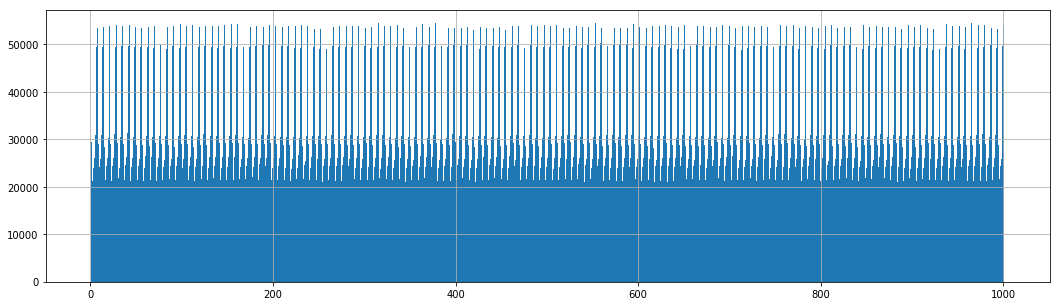

In [40]:
%matplotlib inline
df['visit_day'].hist(bins = 1001, figsize=(18, 5))

We can see there is seasonality in this timeseries. This is likely weekends. Lets explore that theory by adding the day of week to the dataset

In [41]:
def add_day_of_week(index): 
    return (index) % 7

In [42]:
df.loc[df['visitor_id'] == 4].head() # Visitor 4 visited the first day so we can validate whether day_of_week = 1 (Monday)

visitor_id  visit_day
81           4          1
82           4         20
83           4         22
84           4         92
85           4        124

In [44]:
df['day_of_week'] = df['visit_day'].apply(add_day_of_week) # add new column for day of week

In [48]:
df.loc[df['day_of_week'] == 0, 'day_of_week'] = 7 # set all the 0's to 7 (Sunday)
df['day_of_week'] = df['day_of_week'].astype(np.uint8) # convert to uint8 to save memory

In [49]:
df.loc[df['visitor_id'] == 4].head()

visitor_id  visit_day  day_of_week
81           4          1            1
82           4         20            6
83           4         22            1
84           4         92            1
85           4        124            5

In [50]:
df['day_of_week'].value_counts()

7    7691237
6    7079242
5    4388887
1    4135037
4    3722225
3    3460382
2    3067523
Name: day_of_week, dtype: int64

It seems that our hypothesis was correct and that the weekends (6 & 7) are the most popular days to visit the mall

Next we create week_number

In [52]:
df['week_number'] = (np.floor((df['visit_day']-1) / 7) + 1).astype(np.uint32) # Through some trail and error I found this works

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33544533 entries, 0 to 33544532
Data columns (total 4 columns):
visitor_id     uint32
visit_day      uint32
day_of_week    uint8
week_number    uint32
dtypes: uint32(3), uint8(1)
memory usage: 415.9 MB


Export to feather to use later

In [55]:
df.to_feather(LOC + 'df')

## Approach

To solve this classification problem we are going to:
- Create dummy variables for each day of week
- Aggregate this time series to weekly. We want to predict the next week.
- Do feature engineering
- Treat each day as a binary classification problem. This will give us the probably of a customer visiting a spesific day in a spesific week. Hence we will have 8 binary classification models (7 days of the week + 0 for no visit)
- Use the highest predicted value for each customer and use that as the prediction for the following week

### Get dummy variables

In [56]:
df = pd.read_feather(LOC+'df')

In [57]:
dow_dummies = pd.get_dummies(df['day_of_week'], prefix='dow')

Now we join back dummies to original data

In [ ]:
df = df.merge(dow_dummies, left_index = True, right_index = True)

In [59]:
df.head()

visitor_id  visit_day  day_of_week  week_number  dow_1  dow_2  dow_3  \
0           1         30            2            5      0      1      0   
1           1         84            7           12      0      0      0   
2           1        126            7           18      0      0      0   
3           1        135            2           20      0      1      0   
4           1        137            4           20      0      0      0   

   dow_4  dow_5  dow_6  dow_7  
0      0      0      0      0  
1      0      0      0      1  
2      0      0      0      1  
3      0      0      0      0  
4      1      0      0      0

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33544533 entries, 0 to 33544532
Data columns (total 11 columns):
visitor_id     uint32
visit_day      uint32
day_of_week    uint8
week_number    uint32
dow_1          uint8
dow_2          uint8
dow_3          uint8
dow_4          uint8
dow_5          uint8
dow_6          uint8
dow_7          uint8
dtypes: uint32(3), uint8(8)
memory usage: 639.8 MB


### Aggregate to weekly

In [77]:
%%time
df_w = df.groupby(['visitor_id', 'week_number']).agg({'dow_1':sum,
                                                           'dow_2':sum, 
                                                           'dow_3':sum,
                                                           'dow_4':sum,
                                                           'dow_5':sum,
                                                           'dow_6':sum,
                                                           'dow_7':sum
                                                          })

Wall time: 43 s


In [78]:
df_w.head()

dow_1  dow_2  dow_3  dow_4  dow_5  dow_6  dow_7
visitor_id week_number                                                 
1          5                0      1      0      0      0      0      0
           12               0      0      0      0      0      0      1
           18               0      0      0      0      0      0      1
           20               0      1      0      1      0      0      0
           26               0      0      0      1      0      0      0

In [80]:
df_w = df_w.reset_index()

In [85]:
df_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23757045 entries, 0 to 23757044
Data columns (total 9 columns):
visitor_id     uint64
week_number    uint64
dow_1          uint8
dow_2          uint8
dow_3          uint8
dow_4          uint8
dow_5          uint8
dow_6          uint8
dow_7          uint8
dtypes: uint64(2), uint8(7)
memory usage: 521.1 MB


### Account for no visit

Currently our dataset only contains weeks in which a customer made a visit. We need to add additional weeks to the data to represent those weeks where no visit happaned. We can do this by doing a full outer join on a full range of weeks for every customer

The next step creates the full range. We do this by:
- Create a range from 1:300000 to represent visitor_id's
- Repeat every visitor id 143 times to get the full range of weeks for every visitor id
- Set a tempory record = 1
- Use the cumsum of this tempory record to get the week integer values

In [88]:
visitor_ids = pd.Series(range(1, 300001))
visitor_ids_rep = visitor_ids.repeat(143).reset_index(drop=True)
full_range = pd.DataFrame({'visitor_id': visitor_ids_rep})
full_range['record'] = 1
full_range['week_number'] = full_range.groupby('visitor_id')['record'].cumsum()
full_range['visitor_id'] = full_range['visitor_id'].astype(np.uint64)
full_range['week_number'] = full_range['week_number'].astype(np.uint64)

In [89]:
full_range.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42900000 entries, 0 to 42899999
Data columns (total 3 columns):
visitor_id     uint64
record         int64
week_number    uint64
dtypes: int64(1), uint64(2)
memory usage: 981.9 MB


Do the full outer join on the weekly data

In [86]:
%%time
df_w1 = df_w.merge(full_range[['visitor_id','week_number']], 
                  left_on=['visitor_id','week_number'], 
                  right_on=['visitor_id','week_number'], 
                  how = 'outer')
df_w1 = df_w1.sort_values(['visitor_id', 'week_number'])

Wall time: 1min 12s


In [90]:
df_w1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42900000 entries, 23757045 to 23757044
Data columns (total 9 columns):
visitor_id     uint64
week_number    uint64
dow_1          float64
dow_2          float64
dow_3          float64
dow_4          float64
dow_5          float64
dow_6          float64
dow_7          float64
dtypes: float64(7), uint64(2)
memory usage: 3.2 GB


Notice that our dataframe now contains 43 million records. Previously it only had 23.7 million. The new records represent non visits. They are all set to NaN values so we need to impute this with 0

In [91]:
df_w1 = df_w1.fillna(0)

#### total_visits_in_week

Next we create a new column to represent the total number of visits in a spesific week

In [91]:
dow_cols = df_w1.columns[df_w1.columns.str.contains('dow')]
df_w1['total_visits_in_week'] = df_w1[dow_cols].sum(axis=1)
df_w1.tail()

visitor_id  week_number  dow_1  dow_2  dow_3  dow_4  dow_5  dow_6  \
42899999      300000          139    0.0    0.0    0.0    0.0    0.0    0.0   
23757041      300000          140    0.0    0.0    0.0    0.0    1.0    0.0   
23757042      300000          141    1.0    0.0    0.0    0.0    1.0    1.0   
23757043      300000          142    0.0    0.0    0.0    1.0    0.0    1.0   
23757044      300000          143    0.0    0.0    1.0    0.0    0.0    1.0   

          dow_7  total_visits_in_week  
42899999    0.0                   0.0  
23757041    1.0                   2.0  
23757042    1.0                   4.0  
23757043    0.0                   2.0  
23757044    1.0                   3.0

In [92]:
df_w1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42900000 entries, 23757045 to 23757044
Data columns (total 10 columns):
visitor_id              uint64
week_number             uint64
dow_1                   float64
dow_2                   float64
dow_3                   float64
dow_4                   float64
dow_5                   float64
dow_6                   float64
dow_7                   float64
total_visits_in_week    float64
dtypes: float64(8), uint64(2)
memory usage: 3.5 GB


Downcast the values stored as float64 to uint8 to save memory

In [95]:
df_w1_float = df_w1.select_dtypes(include=['float']).columns
df_w1[df_w1_float] = df_w1[df_w1_float].apply(pd.to_numeric, downcast='unsigned')

In [96]:
df_w1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42900000 entries, 23757045 to 23757044
Data columns (total 10 columns):
visitor_id              uint64
week_number             uint64
dow_1                   uint8
dow_2                   uint8
dow_3                   uint8
dow_4                   uint8
dow_5                   uint8
dow_6                   uint8
dow_7                   uint8
total_visits_in_week    uint8
dtypes: uint64(2), uint8(8)
memory usage: 1.3 GB


Nice, the memory usage reduces from 3.5 GB to 1.3 GB

In [98]:
df_w1 = df_w1.reset_index(drop=True)

Let's store this as a feather file to save our progress

In [99]:
df_w1.to_feather(LOC + 'df_w')

And del all the unused object from memory

In [100]:
del df
del df_w
del full_range
del visitor_ids
del visitor_ids_rep

### Freq

We can create the frequency of visits and a spesific point in time by taking the cumulative sum of total_visits_per_week for each visitor

In [101]:
df_w1['freq'] = df_w1.groupby('visitor_id')['total_visits_in_week'].cumsum().astype(np.uint32)

We will remove all the weeks where the customer freq = 0 i.e. the first visit hasn't happened yet

In [102]:
df_w2 = df_w1.loc[~(df_w1['freq'] == 0)].reset_index(drop = True)
df_w2.shape

(42615463, 11)

In [103]:
df_w2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42615463 entries, 0 to 42615462
Data columns (total 11 columns):
visitor_id              uint64
week_number             uint64
dow_1                   uint8
dow_2                   uint8
dow_3                   uint8
dow_4                   uint8
dow_5                   uint8
dow_6                   uint8
dow_7                   uint8
total_visits_in_week    uint8
freq                    uint32
dtypes: uint32(1), uint64(2), uint8(8)
memory usage: 1.1 GB


del df_w1 save some memory :)

In [104]:
del df_w1

In [105]:
df_w2.tail(5)

visitor_id  week_number  dow_1  dow_2  dow_3  dow_4  dow_5  dow_6  \
42615458      300000          139      0      0      0      0      0      0   
42615459      300000          140      0      0      0      0      1      0   
42615460      300000          141      1      0      0      0      1      1   
42615461      300000          142      0      0      0      1      0      1   
42615462      300000          143      0      0      1      0      0      1   

          dow_7  total_visits_in_week  freq  
42615458      0                     0   251  
42615459      1                     2   253  
42615460      1                     4   257  
42615461      0                     2   259  
42615462      1                     3   262

### any_visit_ind

We create a column which tells us whether a visit (on any day) happaned

In [106]:
df_w2['any_visit_ind'] = (df_w2['total_visits_in_week'] > 0).astype(np.uint8)

In [107]:
df_w2.head()

visitor_id  week_number  dow_1  dow_2  dow_3  dow_4  dow_5  dow_6  dow_7  \
0           1            5      0      1      0      0      0      0      0   
1           1            6      0      0      0      0      0      0      0   
2           1            7      0      0      0      0      0      0      0   
3           1            8      0      0      0      0      0      0      0   
4           1            9      0      0      0      0      0      0      0   

   total_visits_in_week  freq  any_visit_ind  
0                     1     1              1  
1                     0     1              0  
2                     0     1              0  
3                     0     1              0  
4                     0     1              0

### dow_0

The rows which represent no visit is just 1 - any_vist_ind

In [108]:
df_w2['dow_0'] = 1 - df_w2['any_visit_ind']

In [109]:
df_w2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42615463 entries, 0 to 42615462
Data columns (total 13 columns):
visitor_id              uint64
week_number             uint64
dow_1                   uint8
dow_2                   uint8
dow_3                   uint8
dow_4                   uint8
dow_5                   uint8
dow_6                   uint8
dow_7                   uint8
total_visits_in_week    uint8
freq                    uint32
any_visit_ind           uint8
dow_0                   uint8
dtypes: uint32(1), uint64(2), uint8(10)
memory usage: 1.2 GB


### weeks_since_previous_visit

Your previous visit will probably effect your next visit so lets get weeks_since_previous_visit

In [110]:
%%time
weeks_since_prev_visit = []
for r in df_w2['any_visit_ind']:
    if r == 1.0:
        c=1.0
    else:
        c+=1.0
    weeks_since_prev_visit.append(c)

Wall time: 9.65 s


In [111]:
weeks_since_prev_visit = pd.DataFrame({'weeks_since_prev_visit':weeks_since_prev_visit})

In [112]:
df_w2 = pd.concat([df_w2, weeks_since_prev_visit], axis=1)

In [115]:
df_w2['weeks_since_prev_visit'] = df_w2['weeks_since_prev_visit'].astype(np.uint32)

In [116]:
df_w2.head(5)

visitor_id  week_number  dow_1  dow_2  dow_3  dow_4  dow_5  dow_6  dow_7  \
0           1            5      0      1      0      0      0      0      0   
1           1            6      0      0      0      0      0      0      0   
2           1            7      0      0      0      0      0      0      0   
3           1            8      0      0      0      0      0      0      0   
4           1            9      0      0      0      0      0      0      0   

   total_visits_in_week  freq  any_visit_ind  dow_0  weeks_since_prev_visit  
0                     1     1              1      0                       1  
1                     0     1              0      1                       2  
2                     0     1              0      1                       3  
3                     0     1              0      1                       4  
4                     0     1              0      1                       5

In [117]:
df_w2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42615463 entries, 0 to 42615462
Data columns (total 14 columns):
visitor_id                uint64
week_number               uint64
dow_1                     uint8
dow_2                     uint8
dow_3                     uint8
dow_4                     uint8
dow_5                     uint8
dow_6                     uint8
dow_7                     uint8
total_visits_in_week      uint8
freq                      uint32
any_visit_ind             uint8
dow_0                     uint8
weeks_since_prev_visit    uint32
dtypes: uint32(2), uint64(2), uint8(10)
memory usage: 1.3 GB


In [118]:
df_w2.to_feather(LOC + 'df_w2')

### tot_dow

Get the total number of visits for a spesific day_of_week. The reasoning for this feature: Someone who has visited on Monday often is likely to visit on Monday again.

In [119]:
%%time
df_w2['tot_dow_0'] = df_w2.groupby('visitor_id')['dow_0'].cumsum().astype(np.uint32)
df_w2['tot_dow_1'] = df_w2.groupby('visitor_id')['dow_1'].cumsum().astype(np.uint32)
df_w2['tot_dow_2'] = df_w2.groupby('visitor_id')['dow_2'].cumsum().astype(np.uint32)
df_w2['tot_dow_3'] = df_w2.groupby('visitor_id')['dow_3'].cumsum().astype(np.uint32)
df_w2['tot_dow_4'] = df_w2.groupby('visitor_id')['dow_4'].cumsum().astype(np.uint32)
df_w2['tot_dow_5'] = df_w2.groupby('visitor_id')['dow_5'].cumsum().astype(np.uint32)
df_w2['tot_dow_6'] = df_w2.groupby('visitor_id')['dow_6'].cumsum().astype(np.uint32)
df_w2['tot_dow_7'] = df_w2.groupby('visitor_id')['dow_7'].cumsum().astype(np.uint32)

Wall time: 38.5 s


In [120]:
display_all(df_w2.head())

visitor_id  week_number  dow_1  dow_2  dow_3  dow_4  dow_5  dow_6  dow_7  \
0           1            5      0      1      0      0      0      0      0   
1           1            6      0      0      0      0      0      0      0   
2           1            7      0      0      0      0      0      0      0   
3           1            8      0      0      0      0      0      0      0   
4           1            9      0      0      0      0      0      0      0   

   total_visits_in_week  freq  any_visit_ind  dow_0  weeks_since_prev_visit  \
0                     1     1              1      0                       1   
1                     0     1              0      1                       2   
2                     0     1              0      1                       3   
3                     0     1              0      1                       4   
4                     0     1              0      1                       5   

   tot_dow_0  tot_dow_1  tot_dow_2  tot_dow_3  tot_dow_4  tot_dow_5  \
0          0          0          1          0          0          0   
1          1          0          1          0          0          0   
2          2          0          1          0          0          0   
3          3          0          1          0          0          0   
4          4          0          1          0          0          0   

   tot_dow_6  tot_dow_7  
0          0          0  
1          0          0  
2          0          0  
3          0          0  
4          0          0

In [121]:
df_w2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42615463 entries, 0 to 42615462
Data columns (total 22 columns):
visitor_id                uint64
week_number               uint64
dow_1                     uint8
dow_2                     uint8
dow_3                     uint8
dow_4                     uint8
dow_5                     uint8
dow_6                     uint8
dow_7                     uint8
total_visits_in_week      uint8
freq                      uint32
any_visit_ind             uint8
dow_0                     uint8
weeks_since_prev_visit    uint32
tot_dow_0                 uint32
tot_dow_1                 uint32
tot_dow_2                 uint32
tot_dow_3                 uint32
tot_dow_4                 uint32
tot_dow_5                 uint32
tot_dow_6                 uint32
tot_dow_7                 uint32
dtypes: uint32(10), uint64(2), uint8(10)
memory usage: 2.6 GB


### prop_dow

We can get the day_of_week proportion of their total visits by just dividing with freq. Reasoning: If someone has visited 10 times and 9 out of 10 were on Sunay, they are likely to visit again on a Sunday. Non visits is calculated slightly differently because we want the proportion of non visits of out the full timerange

In [125]:
df_w2['prop_dow_0'] = pd.to_numeric(df_w2['tot_dow_0'] / (df_w2['freq'] + df_w2['tot_dow_0']), downcast = 'float')
df_w2['prop_dow_1'] = pd.to_numeric(df_w2['tot_dow_1'] / df_w2['freq'], downcast = 'float')
df_w2['prop_dow_2'] = pd.to_numeric(df_w2['tot_dow_2'] / df_w2['freq'], downcast = 'float')
df_w2['prop_dow_3'] = pd.to_numeric(df_w2['tot_dow_3'] / df_w2['freq'], downcast = 'float')
df_w2['prop_dow_4'] = pd.to_numeric(df_w2['tot_dow_4'] / df_w2['freq'], downcast = 'float')
df_w2['prop_dow_5'] = pd.to_numeric(df_w2['tot_dow_5'] / df_w2['freq'], downcast = 'float')
df_w2['prop_dow_6'] = pd.to_numeric(df_w2['tot_dow_6'] / df_w2['freq'], downcast = 'float')
df_w2['prop_dow_7'] = pd.to_numeric(df_w2['tot_dow_7'] / df_w2['freq'], downcast = 'float')

In [126]:
df_w2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42615463 entries, 0 to 42615462
Data columns (total 30 columns):
visitor_id                uint64
week_number               uint64
dow_1                     uint8
dow_2                     uint8
dow_3                     uint8
dow_4                     uint8
dow_5                     uint8
dow_6                     uint8
dow_7                     uint8
total_visits_in_week      uint8
freq                      uint32
any_visit_ind             uint8
dow_0                     uint8
weeks_since_prev_visit    uint32
tot_dow_0                 uint32
tot_dow_1                 uint32
tot_dow_2                 uint32
tot_dow_3                 uint32
tot_dow_4                 uint32
tot_dow_5                 uint32
tot_dow_6                 uint32
tot_dow_7                 uint32
prop_dow_0                float32
prop_dow_1                float32
prop_dow_2                float32
prop_dow_3                float32
prop_dow_4                float32

Finally we need to shift all the features to the next time period. When we are predicting we are going to use the previous week information to predict this week

In [127]:
df_w2.to_feather(LOC + 'df_w2')

In [139]:
df_w2 = pd.read_feather(LOC + 'df_w2')

## Shift features 1 period

Get a list of features to shift

In [140]:
features_tot_dow = list(df_w2.columns[df_w2.columns.str.contains('tot_dow')].values)
features_prop_dow = list(df_w2.columns[df_w2.columns.str.contains('prop_dow')].values)
features_other = ['freq', 'weeks_since_prev_visit']
features = []
features.extend(features_tot_dow)
features.extend(features_prop_dow)
features.extend(features_other)
features

['tot_dow_0',
 'tot_dow_1',
 'tot_dow_2',
 'tot_dow_3',
 'tot_dow_4',
 'tot_dow_5',
 'tot_dow_6',
 'tot_dow_7',
 'prop_dow_0',
 'prop_dow_1',
 'prop_dow_2',
 'prop_dow_3',
 'prop_dow_4',
 'prop_dow_5',
 'prop_dow_6',
 'prop_dow_7',
 'freq',
 'weeks_since_prev_visit']

In [141]:
df_w2[features] = df_w2.groupby('visitor_id')[features].shift(1)

In [142]:
df_w2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42615463 entries, 0 to 42615462
Data columns (total 30 columns):
visitor_id                uint64
week_number               uint64
dow_1                     uint8
dow_2                     uint8
dow_3                     uint8
dow_4                     uint8
dow_5                     uint8
dow_6                     uint8
dow_7                     uint8
total_visits_in_week      uint8
freq                      float64
any_visit_ind             uint8
dow_0                     uint8
weeks_since_prev_visit    float64
tot_dow_0                 float64
tot_dow_1                 float64
tot_dow_2                 float64
tot_dow_3                 float64
tot_dow_4                 float64
tot_dow_5                 float64
tot_dow_6                 float64
tot_dow_7                 float64
prop_dow_0                float32
prop_dow_1                float32
prop_dow_2                float32
prop_dow_3                float32
prop_dow_4             

Again we need to downcast all the float64 values

In [143]:
df_w2_float = df_w2.select_dtypes(include=['float']).columns
df_w2[df_w2_float] = df_w2[df_w2_float].apply(pd.to_numeric, downcast='float')

In [145]:
display_all(df_w2.head())

visitor_id  week_number  dow_1  dow_2  dow_3  dow_4  dow_5  dow_6  dow_7  \
0           1            5      0      1      0      0      0      0      0   
1           1            6      0      0      0      0      0      0      0   
2           1            7      0      0      0      0      0      0      0   
3           1            8      0      0      0      0      0      0      0   
4           1            9      0      0      0      0      0      0      0   

   total_visits_in_week  freq  any_visit_ind  dow_0  weeks_since_prev_visit  \
0                     1   NaN              1      0                     NaN   
1                     0   1.0              0      1                     1.0   
2                     0   1.0              0      1                     2.0   
3                     0   1.0              0      1                     3.0   
4                     0   1.0              0      1                     4.0   

   tot_dow_0  tot_dow_1  tot_dow_2  tot_dow_3  tot_dow_4  tot_dow_5  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        0.0        0.0        1.0        0.0        0.0        0.0   
2        1.0        0.0        1.0        0.0        0.0        0.0   
3        2.0        0.0        1.0        0.0        0.0        0.0   
4        3.0        0.0        1.0        0.0        0.0        0.0   

   tot_dow_6  tot_dow_7  prop_dow_0  prop_dow_1  prop_dow_2  prop_dow_3  \
0        NaN        NaN         NaN         NaN         NaN         NaN   
1        0.0        0.0    0.000000         0.0         1.0         0.0   
2        0.0        0.0    0.500000         0.0         1.0         0.0   
3        0.0        0.0    0.666667         0.0         1.0         0.0   
4        0.0        0.0    0.750000         0.0         1.0         0.0   

   prop_dow_4  prop_dow_5  prop_dow_6  prop_dow_7  
0         NaN         NaN         NaN         NaN  
1         0.0         0.0         0.0         0.0  
2         0.0         0.0         0.0         0.0  
3         0.0         0.0         0.0         0.0  
4         0.0         0.0         0.0         0.0

We have 42 mil records so I will just remove the 300000 missing values. These are the first visits for every customer

In [153]:
df_w2 = df_w2.loc[~(df_w2['freq'].isnull())].reset_index(drop = True)

In [154]:
display_all(df_w2.head())

visitor_id  week_number  dow_1  dow_2  dow_3  dow_4  dow_5  dow_6  dow_7  \
0           1            6      0      0      0      0      0      0      0   
1           1            7      0      0      0      0      0      0      0   
2           1            8      0      0      0      0      0      0      0   
3           1            9      0      0      0      0      0      0      0   
4           1           10      0      0      0      0      0      0      0   

   total_visits_in_week  freq  any_visit_ind  dow_0  weeks_since_prev_visit  \
0                     0   1.0              0      1                     1.0   
1                     0   1.0              0      1                     2.0   
2                     0   1.0              0      1                     3.0   
3                     0   1.0              0      1                     4.0   
4                     0   1.0              0      1                     5.0   

   tot_dow_0  tot_dow_1  tot_dow_2  tot_dow_3  tot_dow_4  tot_dow_5  \
0        0.0        0.0        1.0        0.0        0.0        0.0   
1        1.0        0.0        1.0        0.0        0.0        0.0   
2        2.0        0.0        1.0        0.0        0.0        0.0   
3        3.0        0.0        1.0        0.0        0.0        0.0   
4        4.0        0.0        1.0        0.0        0.0        0.0   

   tot_dow_6  tot_dow_7  prop_dow_0  prop_dow_1  prop_dow_2  prop_dow_3  \
0        0.0        0.0    0.000000         0.0         1.0         0.0   
1        0.0        0.0    0.500000         0.0         1.0         0.0   
2        0.0        0.0    0.666667         0.0         1.0         0.0   
3        0.0        0.0    0.750000         0.0         1.0         0.0   
4        0.0        0.0    0.800000         0.0         1.0         0.0   

   prop_dow_4  prop_dow_5  prop_dow_6  prop_dow_7  
0         0.0         0.0         0.0         0.0  
1         0.0         0.0         0.0         0.0  
2         0.0         0.0         0.0         0.0  
3         0.0         0.0         0.0         0.0  
4         0.0         0.0         0.0         0.0

In [155]:
df_w2.to_feather(LOC + 'df_w3')

In [158]:
#del df_w
#del df_w1
del df_w2

## Model Building Prep

Finally, we can start the fun part. I decided to use random forest to solve each binary classification. Why only RF? RF is a fairly robust algorithm which has proven to be a top performer in most modelling problems. I also do not have time to try many different models.

In [3]:
df = pd.read_feather(LOC + 'df_w3')

In [6]:
df.shape

(42315463, 30)

For the training set we will use the weeks spanning 130-140. These weeks are closest to the test and validation sets. The valid, test and final test will be the last 3 weeks in our data. I didn't need to make test_final but decided it would be better to have another test to make sure the model is generalizing well 

In [7]:
test_final = df.loc[df['week_number'] == 143]
test = df.loc[df['week_number'] == 142]
valid = df.loc[df['week_number'] == 141]
train = df.loc[df['week_number'].isin(range(130, 141))]

In [23]:
del df

In [8]:
print(test.shape)
print(test_final.shape)
print(valid.shape)
print(train.shape)

(300000, 30)
(300000, 30)
(300000, 30)
(3300000, 30)


In [9]:
features_tot_dow = list(df.columns[df.columns.str.contains('tot_dow')].values)
features_prop_dow = list(df.columns[df.columns.str.contains('prop_dow')].values)
features_other = ['freq', 'weeks_since_prev_visit']
features = []
features.extend(features_tot_dow)
features.extend(features_prop_dow)
features.extend(features_other)

I have removed the below features after investigating the plots in the next section. 

In [10]:
features.remove('tot_dow_0') # correlated with prop_dow_0
features.remove('freq') # correlated with prop_dow_0

In [11]:
targets = ['dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'dow_7']

In [12]:
X_train_full = train[features]
y_train_full = train[targets]
X_valid = valid[features]
y_valid = valid[targets]
X_test = test[features]
y_test = test[targets]
X_test_final = test_final[features]
y_test_final = test_final[targets]

In [60]:
display_all(X_train_full.tail())

tot_dow_1  tot_dow_2  tot_dow_3  tot_dow_4  tot_dow_5  tot_dow_6  \
42315455       39.0        5.0       22.0       28.0       35.0       67.0   
42315456       39.0        5.0       22.0       28.0       35.0       68.0   
42315457       40.0        5.0       22.0       28.0       35.0       69.0   
42315458       40.0        6.0       22.0       28.0       36.0       70.0   
42315459       40.0        6.0       22.0       28.0       36.0       70.0   

          tot_dow_7  prop_dow_0  prop_dow_1  prop_dow_2  prop_dow_3  \
42315455       47.0    0.061776    0.160494    0.020576    0.090535   
42315456       47.0    0.061538    0.159836    0.020492    0.090164   
42315457       48.0    0.060837    0.161943    0.020243    0.089069   
42315458       49.0    0.059925    0.159363    0.023904    0.087649   
42315459       49.0    0.063433    0.159363    0.023904    0.087649   

          prop_dow_4  prop_dow_5  prop_dow_6  prop_dow_7  \
42315455    0.115226    0.144033    0.275720    0.193416   
42315456    0.114754    0.143443    0.278689    0.192623   
42315457    0.113360    0.141700    0.279352    0.194332   
42315458    0.111554    0.143426    0.278884    0.195219   
42315459    0.111554    0.143426    0.278884    0.195219   

          weeks_since_prev_visit  
42315455                     1.0  
42315456                     1.0  
42315457                     1.0  
42315458                     1.0  
42315459                     2.0

In [61]:
y_train_full.tail()

dow_0  dow_1  dow_2  dow_3  dow_4  dow_5  dow_6  dow_7
42315455      0      0      0      0      0      0      1      0
42315456      0      1      0      0      0      0      1      1
42315457      0      0      1      0      0      1      1      1
42315458      1      0      0      0      0      0      0      0
42315459      0      0      0      0      0      1      0      1

### Stardardize feature set

In [15]:
from sklearn.preprocessing import StandardScaler

sample_index = X_train_full.sample(300000).index

#X_train = X_train_full.loc[sample_index]
#y_train = y_train_full.loc[sample_index]

X_train = X_train_full
y_train = y_train_full

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
X_test_final = scaler.transform(X_test_final)

C:\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  del sys.path[0]
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype float32 were all conver

### Check feature set correlations

We removed tot_dow_0 and freq because they are highly correlated to prop_dow_0. RF's are actually very good at handling multicolinearity because of the max_features argument so we probably didn't need to do this. However, if other models are tried in the future. It is better to not have these features together.

In [16]:
import scipy
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy as hc

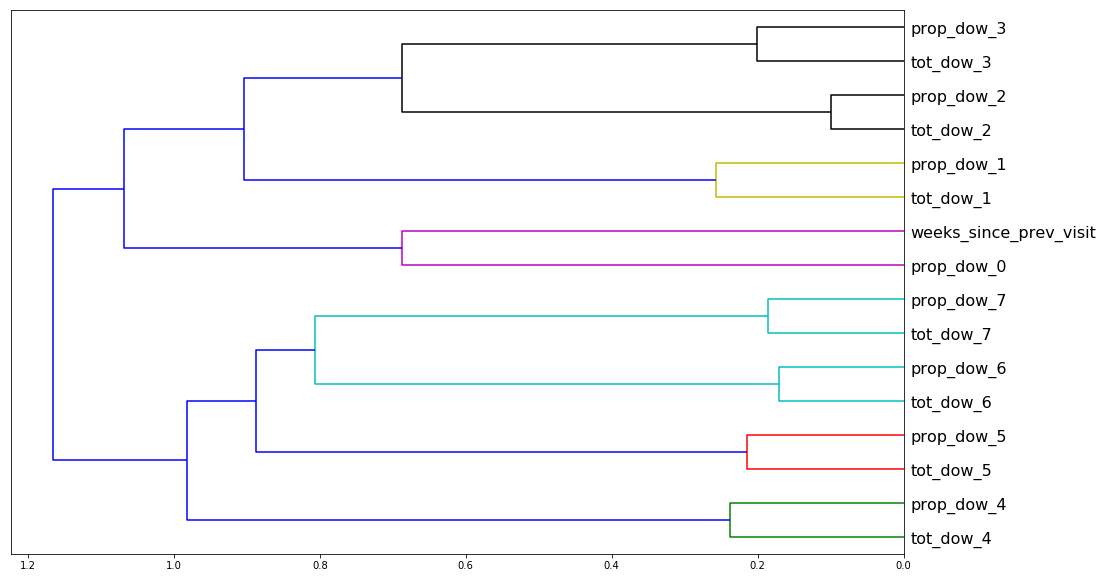

In [17]:
corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train.columns, orientation='left', leaf_font_size=16)
plt.show()

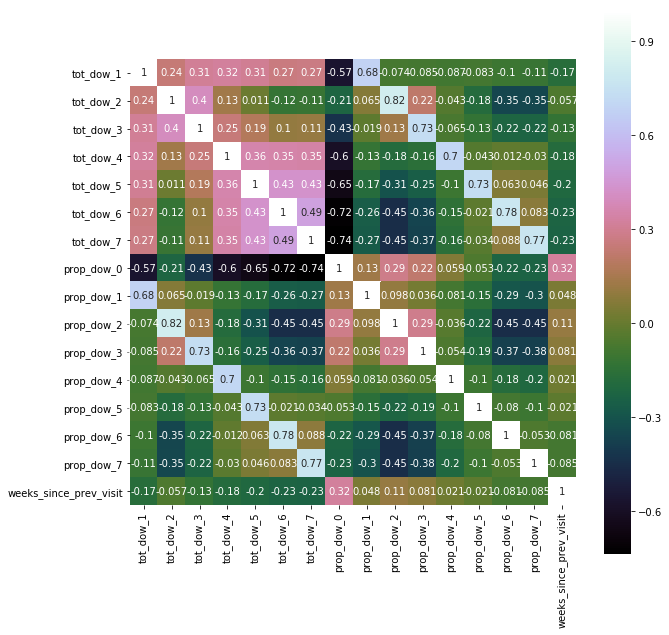

In [18]:
import seaborn as sns 
correlation = X_train.corr()  
plt.figure(figsize=(10, 10))  
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')  

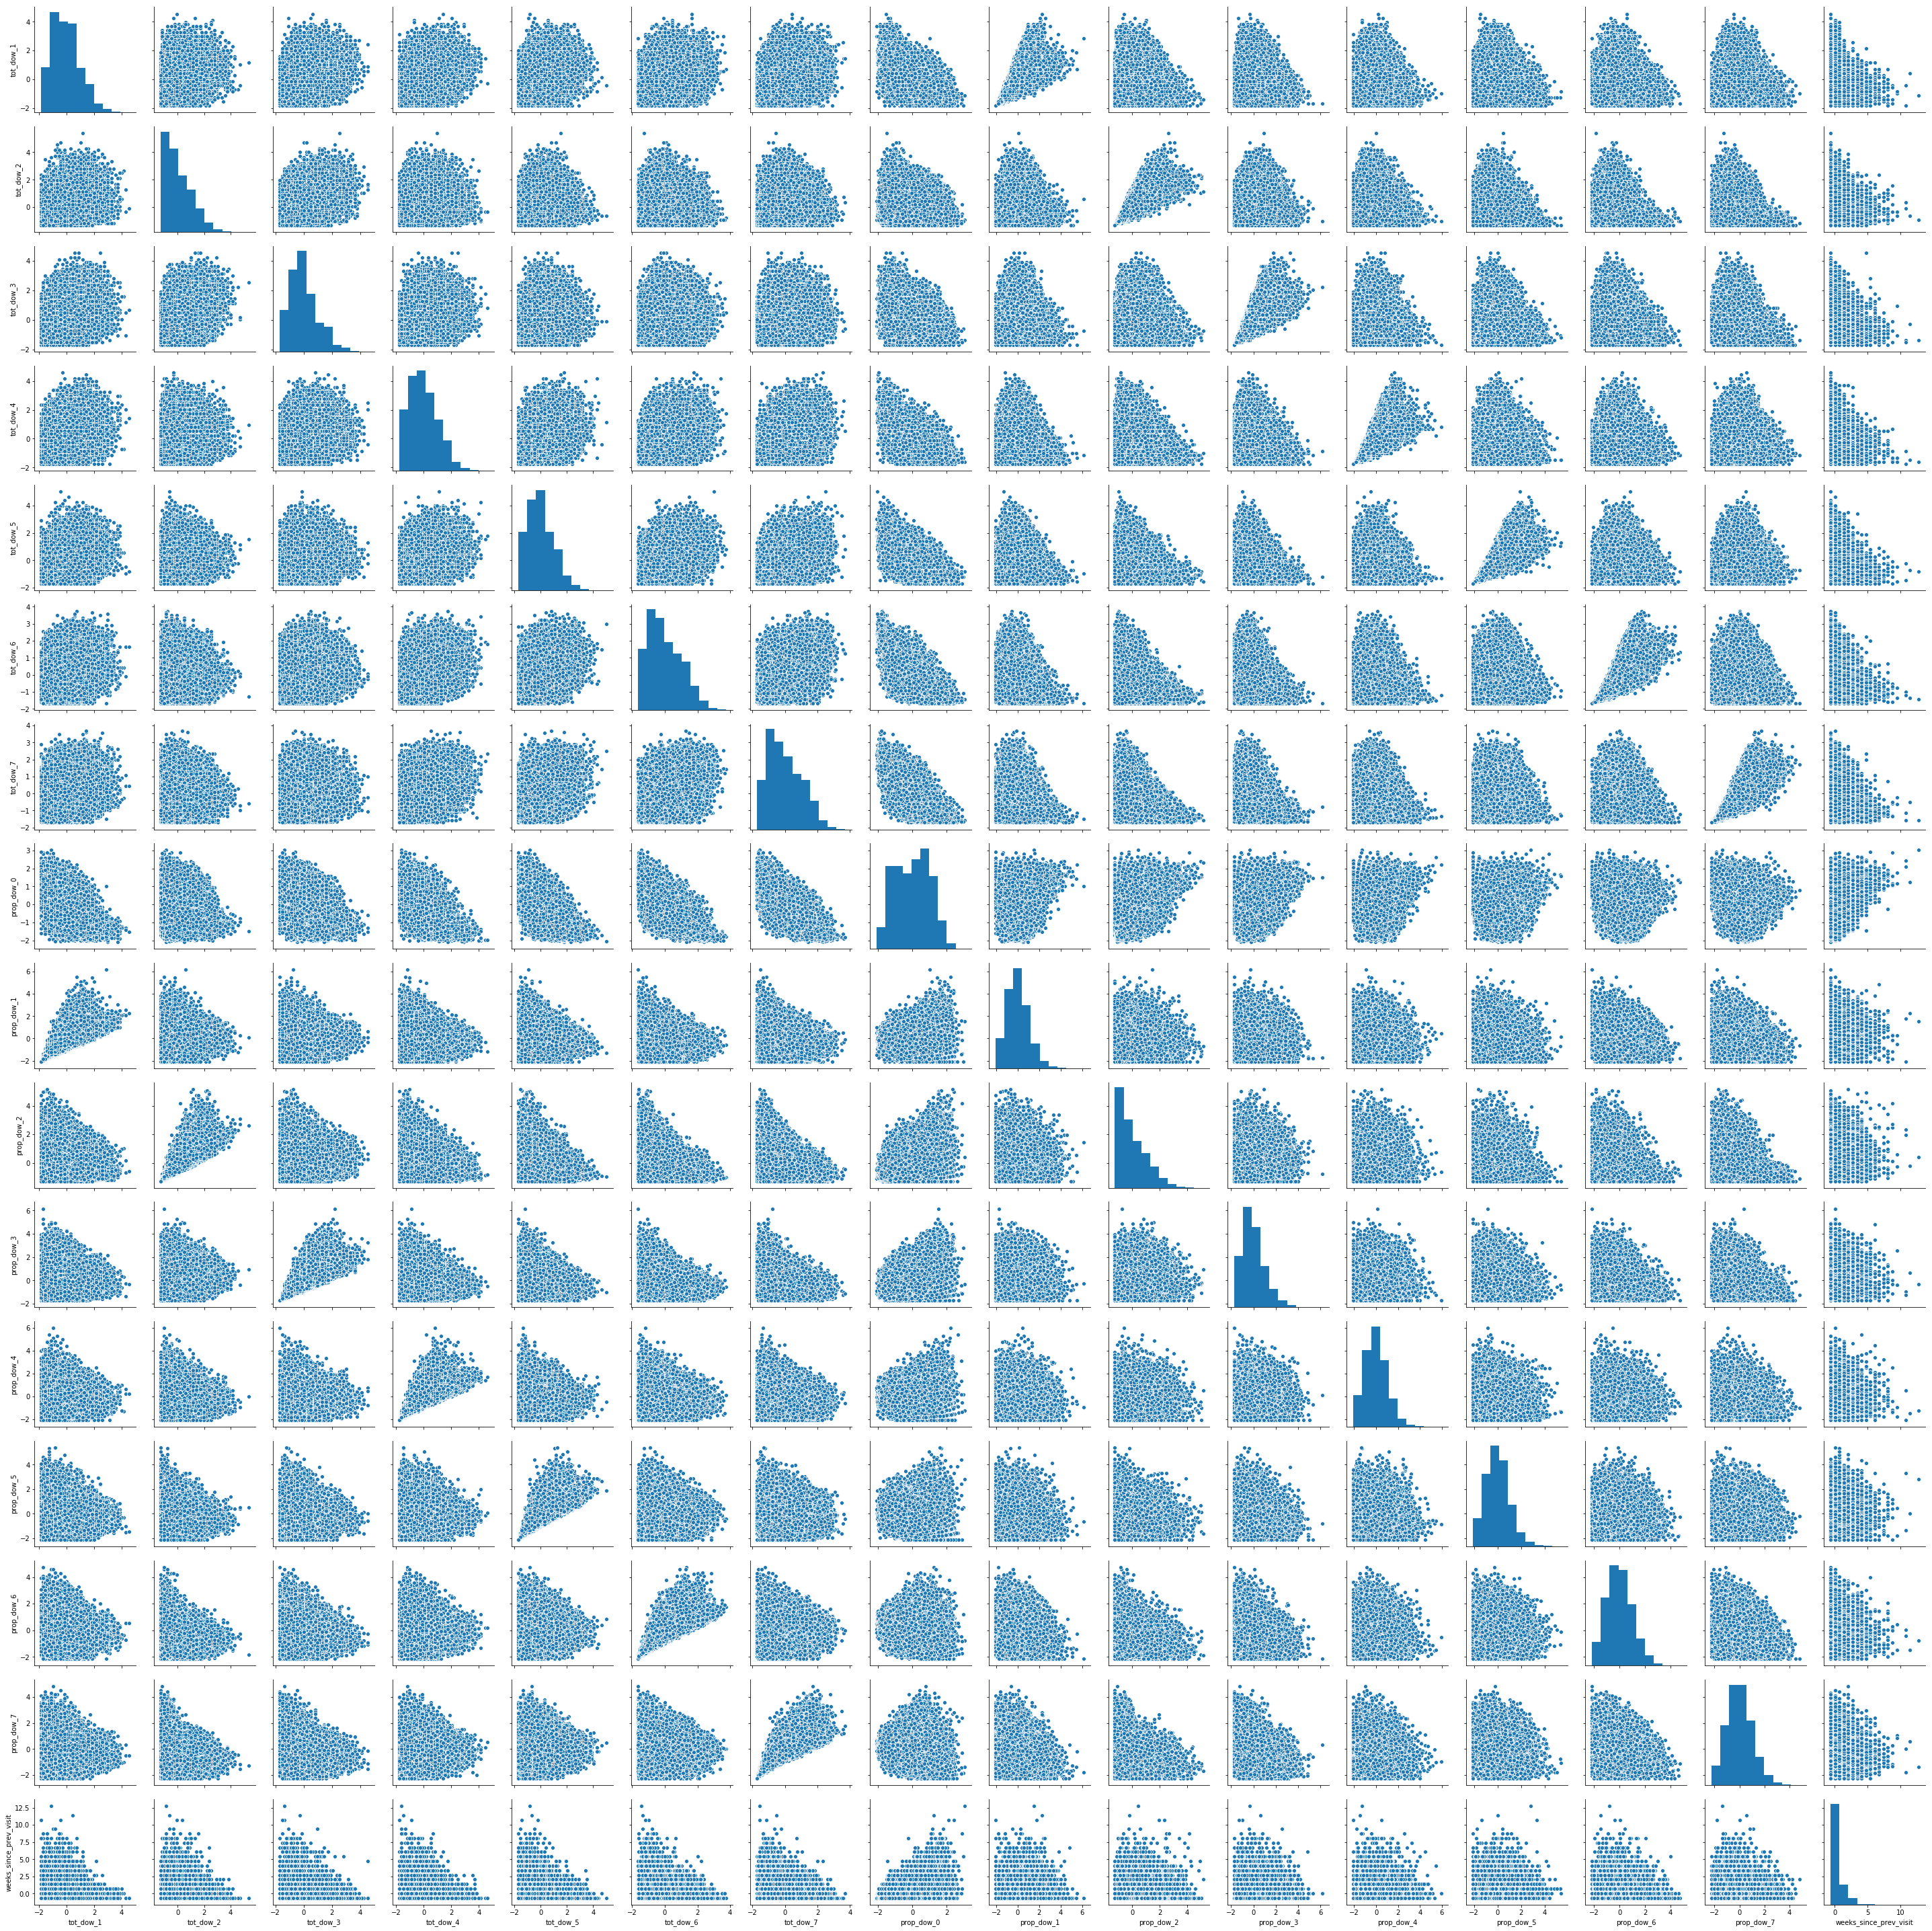

In [19]:
%matplotlib inline
# take a 5% sample as this is computationally expensive
df_sample = X_train.sample(frac=0.01)  
# Pairwise plots
sns.pairplot(df_sample)  

## Model Building

We will be looking at scores all the time to compare different parameter settings so it is much easier to wrap this in a function

In [20]:
import math
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

from sklearn import metrics

def print_score(m, dow):
    res = [rmse(m.predict(X_train), y_train[dow]), 
           rmse(m.predict(X_valid), y_valid[dow]),
           m.score(X_train, y_train[dow]), 
           m.score(X_valid, y_valid[dow])]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import forest


In [24]:
print(X_train.shape)
print(y_train.shape)

(3300000, 16)
(3300000, 8)


In [27]:
train.week_number.unique()

array([130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140], dtype=uint64)

Setting the subsampling parameter in RF's will help reduce overfitting and increase training time 

In [33]:
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

I tried a couple of settings for each random forest parameter and found below performed the best. We could probably spend some more time tuning to get slightly better results.

In [95]:
set_rf_samples(300000)

In [96]:
%%time
target = 'dow_1'
rf_classifier = forest.RandomForestClassifier(n_estimators = 80, 
                                       max_features=0.1, 
                                       min_samples_leaf=3, 
                                       n_jobs = -1, 
                                       oob_score=True, 
                                       class_weight='balanced'
                                      )
rf_classifier.fit(X_train, y_train[target])
print_score(rf_classifier, target)

[0.3101671103834776, 0.31063376077518257, 0.90379636363636362, 0.90350666666666668, 0.90366272727272723]
Wall time: 3min 36s


It takes around 3 min for 1 model. So doing all 7 will take around 20 min

In [103]:
probs = pd.DataFrame(rf_classifier.predict_proba(X_test))
rf_roc_auc = metrics.roc_auc_score(y_test, probs) 
rf_roc_auc

0.59385730934539094

In [104]:
rf_classifier.predict_proba(X_test)[0:5]

array([[ 0.90787501,  0.09212499],
       [ 0.78373358,  0.21626642],
       [ 0.90443307,  0.09556693],
       [ 0.89341826,  0.10658174],
       [ 0.82939807,  0.17060193]])

In [105]:
rf_pred = rf_classifier.predict(X_test)
rf_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [106]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
print(accuracy_score(y_test[target], rf_pred))
cm = confusion_matrix(y_test[target], rf_pred) 
print(cm)

0.904613333333
[[271384      8]
 [ 28608      0]]


In [101]:
def get_feature_importance(m):
    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(features, m.feature_importances_):
        feats[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
    importances = importances.sort_values(by='Importance')
    return importances

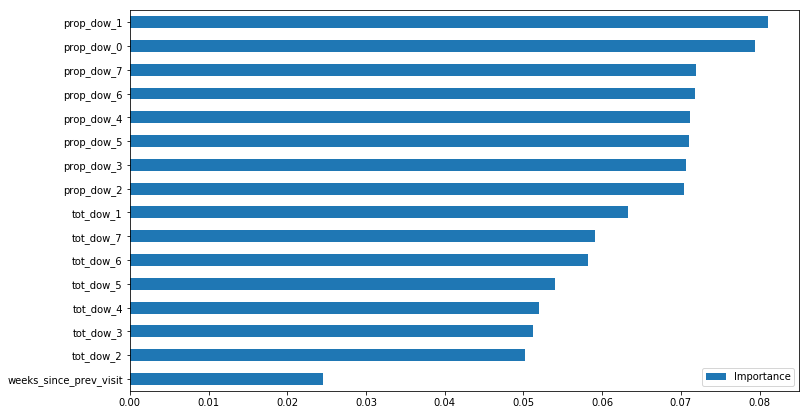

In [102]:
get_feature_importance(rf_classifier).plot(kind='barh', figsize=(12,7))

### Now we do for all

In [49]:
rf_models = {}

for target in targets:
    rf_classifier = forest.RandomForestClassifier(n_estimators = 80, 
                                           max_features=0.1, 
                                           min_samples_leaf=3, 
                                           n_jobs = -1, 
                                           oob_score=True, 
                                           class_weight='balanced')
    rf_classifier.fit(X_train, y_train[target])
    print(target)
    print_score(rf_classifier, target)
    rf_models[target] = rf_classifier  

dow_0
[0.6243199937095195, 0.6285857141233804, 0.61022454545454541, 0.60487999999999997, 0.60652606060606062]
dow_1
[0.3103170421789088, 0.3105908348078975, 0.9037033333333333, 0.9035333333333333, 0.90370303030303034]
dow_2
[0.26683555258100844, 0.2665082863001949, 0.92879878787878789, 0.92897333333333332, 0.92879727272727275]
dow_3
[0.283696914671167, 0.285744641244591, 0.91951606060606061, 0.91835, 0.91951575757575754]
dow_4
[0.2943240844148957, 0.29501977334861246, 0.91337333333333337, 0.91296333333333335, 0.91337333333333337]
dow_5
[0.31988871170891275, 0.31881028841616765, 0.89767121212121215, 0.89836000000000005, 0.89766484848484851]
dow_6
[0.4139923875745748, 0.41788355634873536, 0.82861030303030303, 0.82537333333333329, 0.82764818181818178]
dow_7
[0.4354092467107378, 0.4366539438350084, 0.81041878787878785, 0.80933333333333335, 0.80904727272727273]


In [51]:
rf_models

{'dow_0': RandomForestClassifier(bootstrap=True, class_weight='balanced',
             criterion='gini', max_depth=None, max_features=0.1,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=80, n_jobs=-1, oob_score=True, random_state=None,
             verbose=0, warm_start=False),
 'dow_1': RandomForestClassifier(bootstrap=True, class_weight='balanced',
             criterion='gini', max_depth=None, max_features=0.1,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=80, n_jobs=-1, oob_score=True, random_state=None,
             verbose=0, warm_start=False),
 'dow_2': RandomForestClassifier(bootstrap=True, class_weight='balanced',
             criterion='gini', max_depth=Non

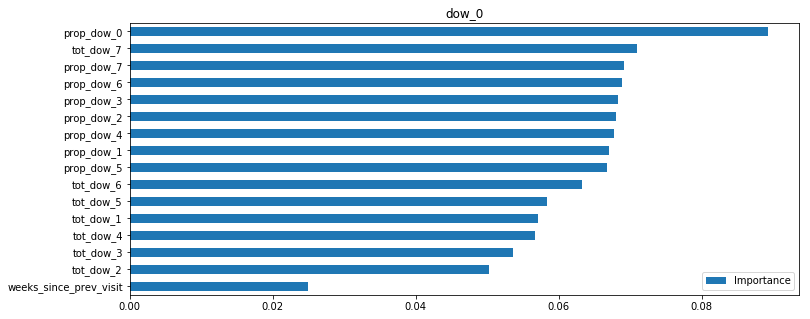

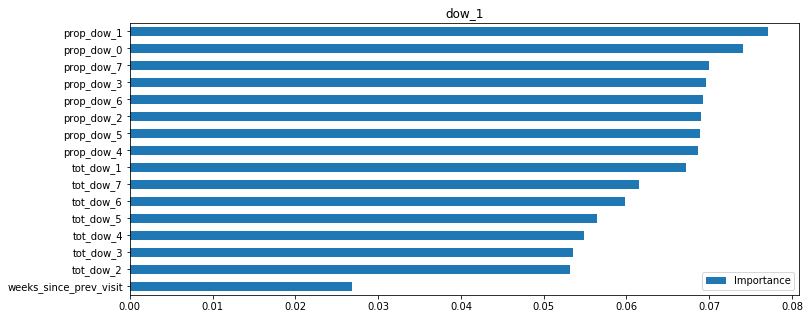

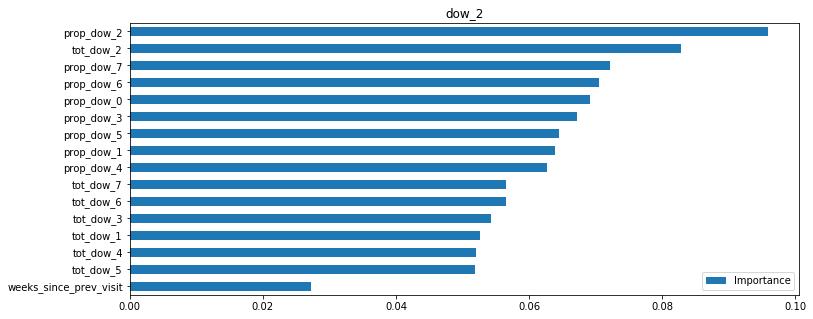

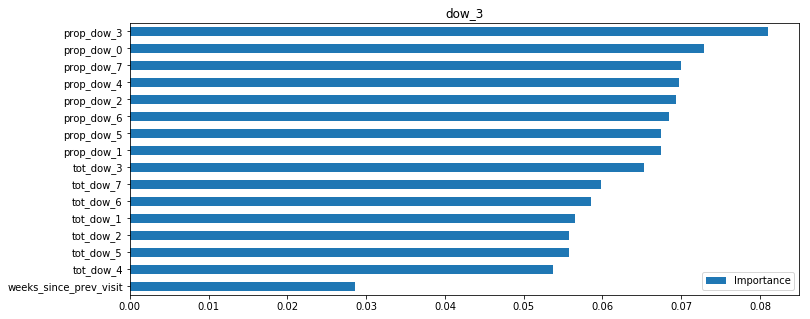

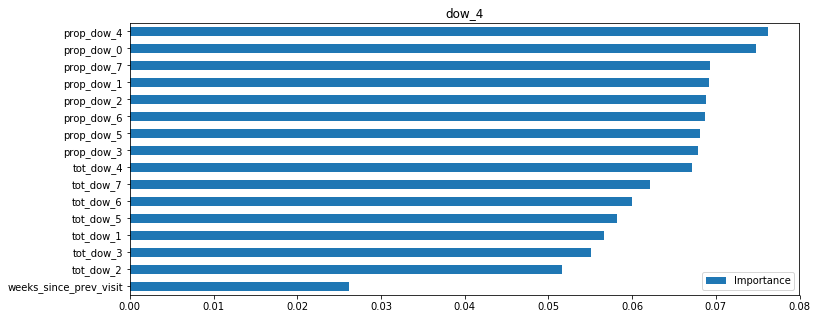

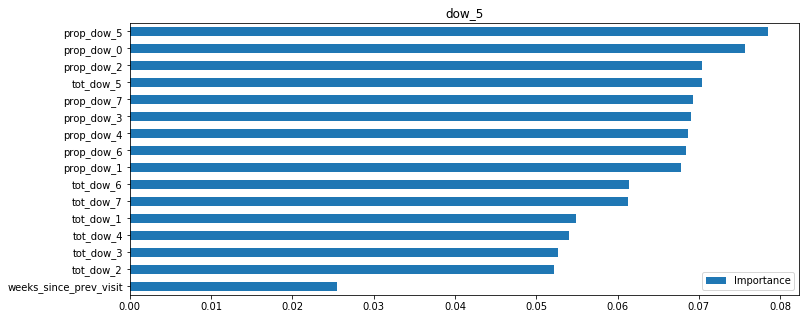

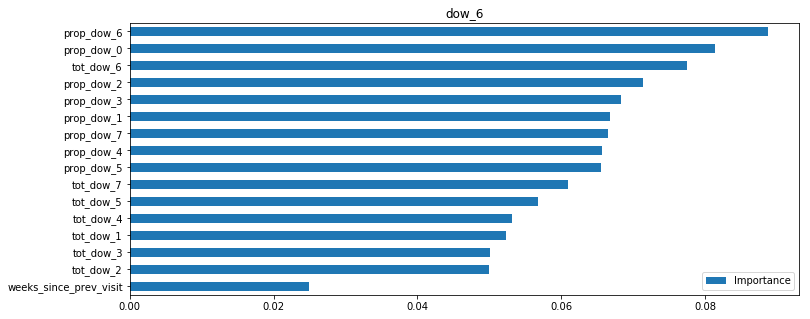

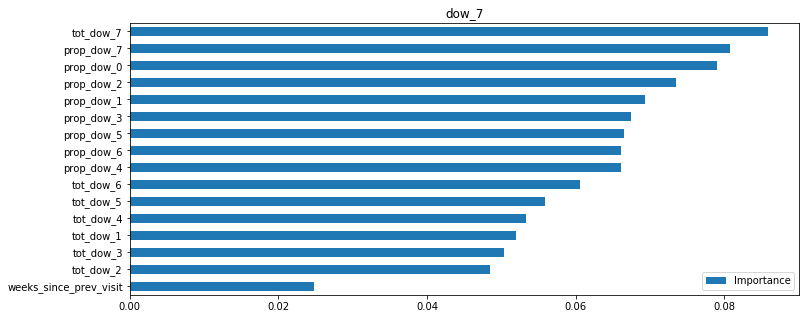

In [82]:
for dow, m in rf_models.items():
    get_feature_importance(m).plot(kind='barh', figsize=(12,5), title=dow) 

In [52]:
train_probs = pd.DataFrame(columns=targets) 
valid_probs = pd.DataFrame(columns=targets)
test_probs = pd.DataFrame(columns=targets)
test_final_probs = pd.DataFrame(columns=targets)

for target in targets:
    # Compute probability of observation being in the origin.
    train_probs[target] = rf_models[target].predict_proba(X_train)[:,1]
    valid_probs[target] = rf_models[target].predict_proba(X_valid)[:,1]
    test_probs[target] = rf_models[target].predict_proba(X_test)[:,1]
    test_final_probs[target] = rf_models[target].predict_proba(X_test)[:,1]    

### Tableau dataset

In [53]:
train_viz = pd.concat([train.reset_index(drop=True), train_probs], axis=1)
valid_viz = pd.concat([valid.reset_index(drop=True), valid_probs], axis=1)
test_viz = pd.concat([test.reset_index(drop=True), test_probs], axis=1)
test_final_viz = pd.concat([test_final.reset_index(drop=True), test_final_probs], axis=1)

In [54]:
train_viz['set'] = 'train'
valid_viz['set'] = 'valid'
test_viz['set'] = 'test'
test_final_viz['set'] = 'test_final'

In [55]:
all_viz = pd.concat([train_viz, valid_viz, test_viz, test_final_viz], axis=0)

In [56]:
all_viz.shape

(4200000, 39)

In [57]:
all_viz.to_csv(LOC + 'all_viz.csv', index=False)

### Check test prediction

In [69]:
test[features].tail()

tot_dow_1  tot_dow_2  tot_dow_3  tot_dow_4  tot_dow_5  tot_dow_6  \
42314893       35.0        3.0        8.0       33.0       30.0       57.0   
42315035       36.0        3.0       13.0       39.0       41.0       53.0   
42315177       33.0       11.0       24.0       29.0       26.0       56.0   
42315319       35.0       13.0       11.0       34.0       28.0       61.0   
42315461       41.0        6.0       22.0       28.0       38.0       71.0   

          tot_dow_7  prop_dow_0  prop_dow_1  prop_dow_2  prop_dow_3  \
42314893       61.0    0.058091    0.154185    0.013216    0.035242   
42315035       60.0    0.054054    0.146939    0.012245    0.053061   
42315177       53.0    0.075697    0.142241    0.047414    0.103448   
42315319       56.0    0.081081    0.147059    0.054622    0.046218   
42315461       51.0    0.062044    0.159533    0.023346    0.085603   

          prop_dow_4  prop_dow_5  prop_dow_6  prop_dow_7  \
42314893    0.145374    0.132159    0.251101    0.268722   
42315035    0.159184    0.167347    0.216327    0.244898   
42315177    0.125000    0.112069    0.241379    0.228448   
42315319    0.142857    0.117647    0.256303    0.235294   
42315461    0.108949    0.147860    0.276265    0.198444   

          weeks_since_prev_visit  
42314893                     1.0  
42315035                     1.0  
42315177                     1.0  
42315319                     1.0  
42315461                     1.0

In [70]:
test[targets].tail()

dow_0  dow_1  dow_2  dow_3  dow_4  dow_5  dow_6  dow_7
42314893      0      1      0      0      0      1      1      1
42315035      0      0      1      0      0      1      1      1
42315177      0      0      0      0      0      1      0      1
42315319      0      1      0      0      0      1      1      1
42315461      0      0      0      0      1      0      1      0

In [72]:
test_probs.tail()

dow_0     dow_1     dow_2     dow_3     dow_4     dow_5     dow_6  \
299995  0.191163  0.326251  0.152521  0.086376  0.206855  0.301744  0.475780   
299996  0.240684  0.329989  0.122027  0.174405  0.279292  0.331807  0.422199   
299997  0.237181  0.276546  0.176591  0.152845  0.204309  0.282943  0.423909   
299998  0.234945  0.366739  0.225863  0.150826  0.226060  0.306162  0.411481   
299999  0.241616  0.364728  0.164382  0.177082  0.261941  0.189212  0.441751   

           dow_7  
299995  0.436982  
299996  0.413696  
299997  0.496557  
299998  0.509231  
299999  0.366171

In [75]:
predicted_day = test_probs.idxmax(axis=1)
predicted_day.head()

0    dow_0
1    dow_0
2    dow_0
3    dow_0
4    dow_0
dtype: object

In [76]:
y_test.reset_index(drop=True).tail()

dow_0  dow_1  dow_2  dow_3  dow_4  dow_5  dow_6  dow_7
299995      0      1      0      0      0      1      1      1
299996      0      0      1      0      0      1      1      1
299997      0      0      0      0      0      1      0      1
299998      0      1      0      0      0      1      1      1
299999      0      0      0      0      1      0      1      0

## Conclusion

There are many machine learning algorithms which can be used for classification problems. I decided on using Random forests because they are easy to implement, give feature importance and can be top performers if tuned correctly.

We use binary classification models to predict the visit probability for each day of week independantly. Hence, the accuracy for each model varies:
- No visits: ~60%
- Day 1: Monday: ~90%
- Day 2: Tuesday: ~90%
- Day 3: Wednesday: ~90%
- Day 4: Thursday: ~90%
- Day 5: Friday: ~90%
- Day 6: Saturday: ~80%
- Day 7: Sunday: ~80%

Reporting these high classification accuracies can be misleading. For example: Our Day 1 predictions, we get around 90% accuracy because our model is predicting all values will be 0 i.e. no customers are predicted to visit on Monday. Because there are so few monday visits (in comparison to other days and no visits) this is not neccesarily a bad prediction. If our task was to predict Mondays more accurately there are other evaluation criteria we could use to force the model to predict more visits as Monday. However, I decided it would be more important to predict accurately overall and hence left these models as is.

To get our final prediction we can predict the day of week which has the highest probability for all 8 models. We could also structure this as a multi-label classification problem and try to correctly predict all visit days in the next week. This decision is dependant on how our model will be used for business applications.

As I mention above, random forest give us the feature importance. For every model, the most important feature to predict the day of week was the proportion of days the customer previously visited on that day. This also makes intuitive sense, for example: If a customer has visited the mall a total of 10 times, and 9 out of the 10 times they visit on a Monday, it is reasonable to predict the next time they visit will be on Monday. 

The other very important feature is the proportion of no visit weeks. Again this makes sense: If we have 2 customers - A and B - Customer A visits at least 1 day a week for 10 weeks while customer B visits only once in 10 weeks. It is reasonable to predict customer A has a higher likelyhood of visiting the next week compared to customer B.

I built 2 [Tableau dashboards]('https://public.tableau.com/profile/ryan3290#!/vizhome/CustomerVisits_0/CustomerVisitDash') to help explain what is happening in this model. 
- Customer Dash is used to see the predictions for an individual customer (visitor_id). This helps us check whether predictions are reasonable.
- Model Feature Dash is used to explore the relationship between the targets (day of week) and features.

### Next steps / Further Improvements

Our final models are giving reasonable results. However, they are not doing well at predicting rare events. To solve this we will need to do additional feature engineering. We could try other modelling approaches. We should try to collect more metadata like weather on spesific days or whether it was a public holidays / promotions in the mall. 

Given that there are some time constraints, I unfortunatley didn't have enough time to try many different models or do more feature engineering. I would really like to try using deep learning to solve this classification problem. Deep learning can be really good at solving problems that require a lot of feature engineering.

As a final comment. I enjoyed working on this. I hope you enjoy reading and going through this notebook. If you have any comments or questions, you can get in touch through email: ryanfras@gmail.com
